<a href="https://colab.research.google.com/github/jazkre/01ZLMA/blob/main/R/01ZLMA_ex04_GLM_model_testing_and_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01ZLMA - Exercise 04

Exercise 04 of the course 01ZLMA. 

## Contents

* Statistical Inference - part 2
 ---
* Testing - part 2
 ---
* Model comparison
 ---
* Model selection
 ---


In [ ]:
library(tidyverse)
library(lubridate)
library(MASS)

#For sure: set dplyr functions
select    <- dplyr::select;
rename    <- dplyr::rename;
mutate    <- dplyr::mutate; 
summarize <- dplyr::summarize;
arrange   <- dplyr::arrange;
slice     <- dplyr::slice;
filter    <- dplyr::filter;
recode    <- dplyr::recode

install.packages("GLMsData")
library(GLMsData) #toto hodne vyuzivame :)
#install.packages("splines")
#library(splines)
#install.packages("statmod")
#library(statmod)
#install.packages("tweedie")
#library(tweedie)
install.packages("GGally")
library(GGally)

In [ ]:
data(nminer)
head(nminer)
summary(nminer)
? nminer

In [ ]:
options(repr.plot.width = 20, repr.plot.height = 20, repr.plot.res = 100)
ggpairs(nminer)

In [ ]:
with(nminer,plot(Eucs,Minerab))
# Eucs is number of eucalypts per 2 ha 

In [ ]:
? family

In [ ]:
model_1 <- glm( Minerab ~ Eucs,
                   data=nminer,
                   family=poisson,                    # (link = "log") keď nič nevyplnim, tak spojovacia fcia automaticky logaritmus
                   control=glm.control(maxit=2,       # Max number of iterations
                                       epsilon=1e-15, # Stopping criterion
                                       trace=TRUE)    # See results from each iteration?
              ) 
summary(model_1)


 The estimates $\beta^j$ are found by Fisher scoring, using the
iteratively reweighted least squares algorithm.

The covariance matrix of the regression
parameters is estimated from inverse information matrix

$$ var[\hat{\beta}] = I^{-1} = \phi (X^T \hat{W} X)^{-1}$$
and 
$$ se[\hat{\beta}_j] = \sqrt{\phi} v_j,$$

where the $v_j$ are the square-root diagonal elements of $(X^T \hat{W} X)^{-1}$.

rozptyly pre bery na diagonale FIM

teraz to spočítame ručne: 

In [ ]:
 cov_mat <- summary(model_1)$cov.scaled
# Covariance matrix
round(cov_mat, digits=4)
# Square-root of its diagonal elements 
sqrt(diag(cov_mat))
#summary(model_1)$coef

## Wald Tests for Single Regression Coefficients

The Wald test of the null hypothesis $H_0: \beta_j = \beta_j^0$, where $\beta_j^0$ is typically zero.



In [ ]:
model_1 <- glm( Minerab ~ Eucs, data=nminer, family=poisson, control=list(trace=F) ) # (link = "log")
coef(summary(model_1))
confint(model_1)


## Confidence Intervals for Individual Coefficients


## Confidence Intervals for $\mu$

The variance of $\hat{\mu}$ is found by first considering $\hat{\eta}$. Consider given values of the $p$ explanatory variables ${x_{new}}$. The variance of  $\hat{\eta}$ is
$$ var[ \hat{\eta}] = var[x_{new} \hat{\beta}] = x_{new}(X^T \hat{W} X)^{-1} x_{new}^T$$
where some estimate of $\phi$ must be used if the value of $\phi$ is unknown. 

The variance of $\hat{\eta}$ is harder to compute directly. However, for inference involving $\mu$ (such as confidence intervals for $\mu$), we work with $\hat{\eta}$ and then convert to $\hat{\mu}$ by
$$ \mu = g^{-1}(\eta).$$



je konfidenčný interval všade stejny pre vš xka? NIE

je symetrický? to záleží na rozdelení. nemusí byť obecne symetrický a nie je všade rovnaky

uvidime na dalšom obrazku

In [ ]:
# By default, this computes statistics on the linear predictor scale:
out <- predict( model_1, newdata=data.frame(Eucs=10), se.fit=TRUE) 
# Return predictions on mu scale
out2 <- predict(model_1, newdata=data.frame(Eucs=10), se.fit=TRUE, type="response") 
# Both methods give the same answer
c( exp( out$fit ), out2$fit ) 


In [ ]:
newEucs <- seq(0, 35, length=100)
newMab <- predict(model_1, se.fit=TRUE, newdata=data.frame(Eucs=newEucs))
zstar <- qnorm(p=0.975) # For 95% CI
ci_lo <- exp(newMab$fit-zstar*newMab$se.fit)
ci_hi <- exp(newMab$fit+zstar*newMab$se.fit)
length(ci_lo)
length(newEucs)

In [ ]:
plot( Minerab~Eucs, data=nminer,
xlim=c(0, 35), ylim=c(0, 20), las=1, pch=19,
xlab="No. eucalypts per 2 ha transect", ylab="No. noisy miners")
lines(exp(newMab$fit) ~ newEucs, lwd=2)
lines(ci_lo ~ newEucs, lty=2)
lines(ci_hi ~ newEucs, lty=2)

pozorovania ležia mimo interval, ale my očakavame **strednu hodnotu** vo vnutri intervali

In [ ]:
# This confidence interval is not symmetric
cbind(ci_lo[1:10]-exp(newMab$fit)[1:10],ci_hi[1:10]-exp(newMab$fit)[1:10])


In [ ]:
install.packages("statmod")
library(statmod)
? glm.scoretest()

Wald statistics:
$$W_n = (\hat{\beta} - \beta^0)^T I(\beta)(\hat{\beta} - \beta^0) \sim \chi_p^2 $$
if we know Dispersion parameter $\phi$ and we test only one parametr (leave one out) then $W \rightarrow Z$ and $\chi_p^2 \rightarrow N(0,1)$. 

Scale deviance statistics (likelihood ratio):
$${S(y,\hat{\mu},\phi)}=2\left[l(\tilde{\mu},\phi;y)-l(\hat{\mu},\phi;y)\right]
=2\sum_{i=1}^{n}\frac{y_{i}(\tilde{\theta}_{i}-\hat{\theta}_{i})
-\left(b(\tilde{\theta}_{i})-b(\hat{\theta}_{i})\right)}{a_{i}(\phi)} = \frac{D(y,\hat{\mu})}{\phi}  \sim \chi^2_{n-p} (approximative).
$$

Rao Score statistics ($H_0: g(\mu) = X\beta$):
$$R_n(\hat{\mu}, \phi) = U^T(\hat{\mu}) I^{-1}(\hat{\mu})U(\hat{\mu})  \sim \chi^2_{n-p}$$







See: https://link.springer.com/content/pdf/10.1007%2F978-1-4419-0118-7_4.pdf

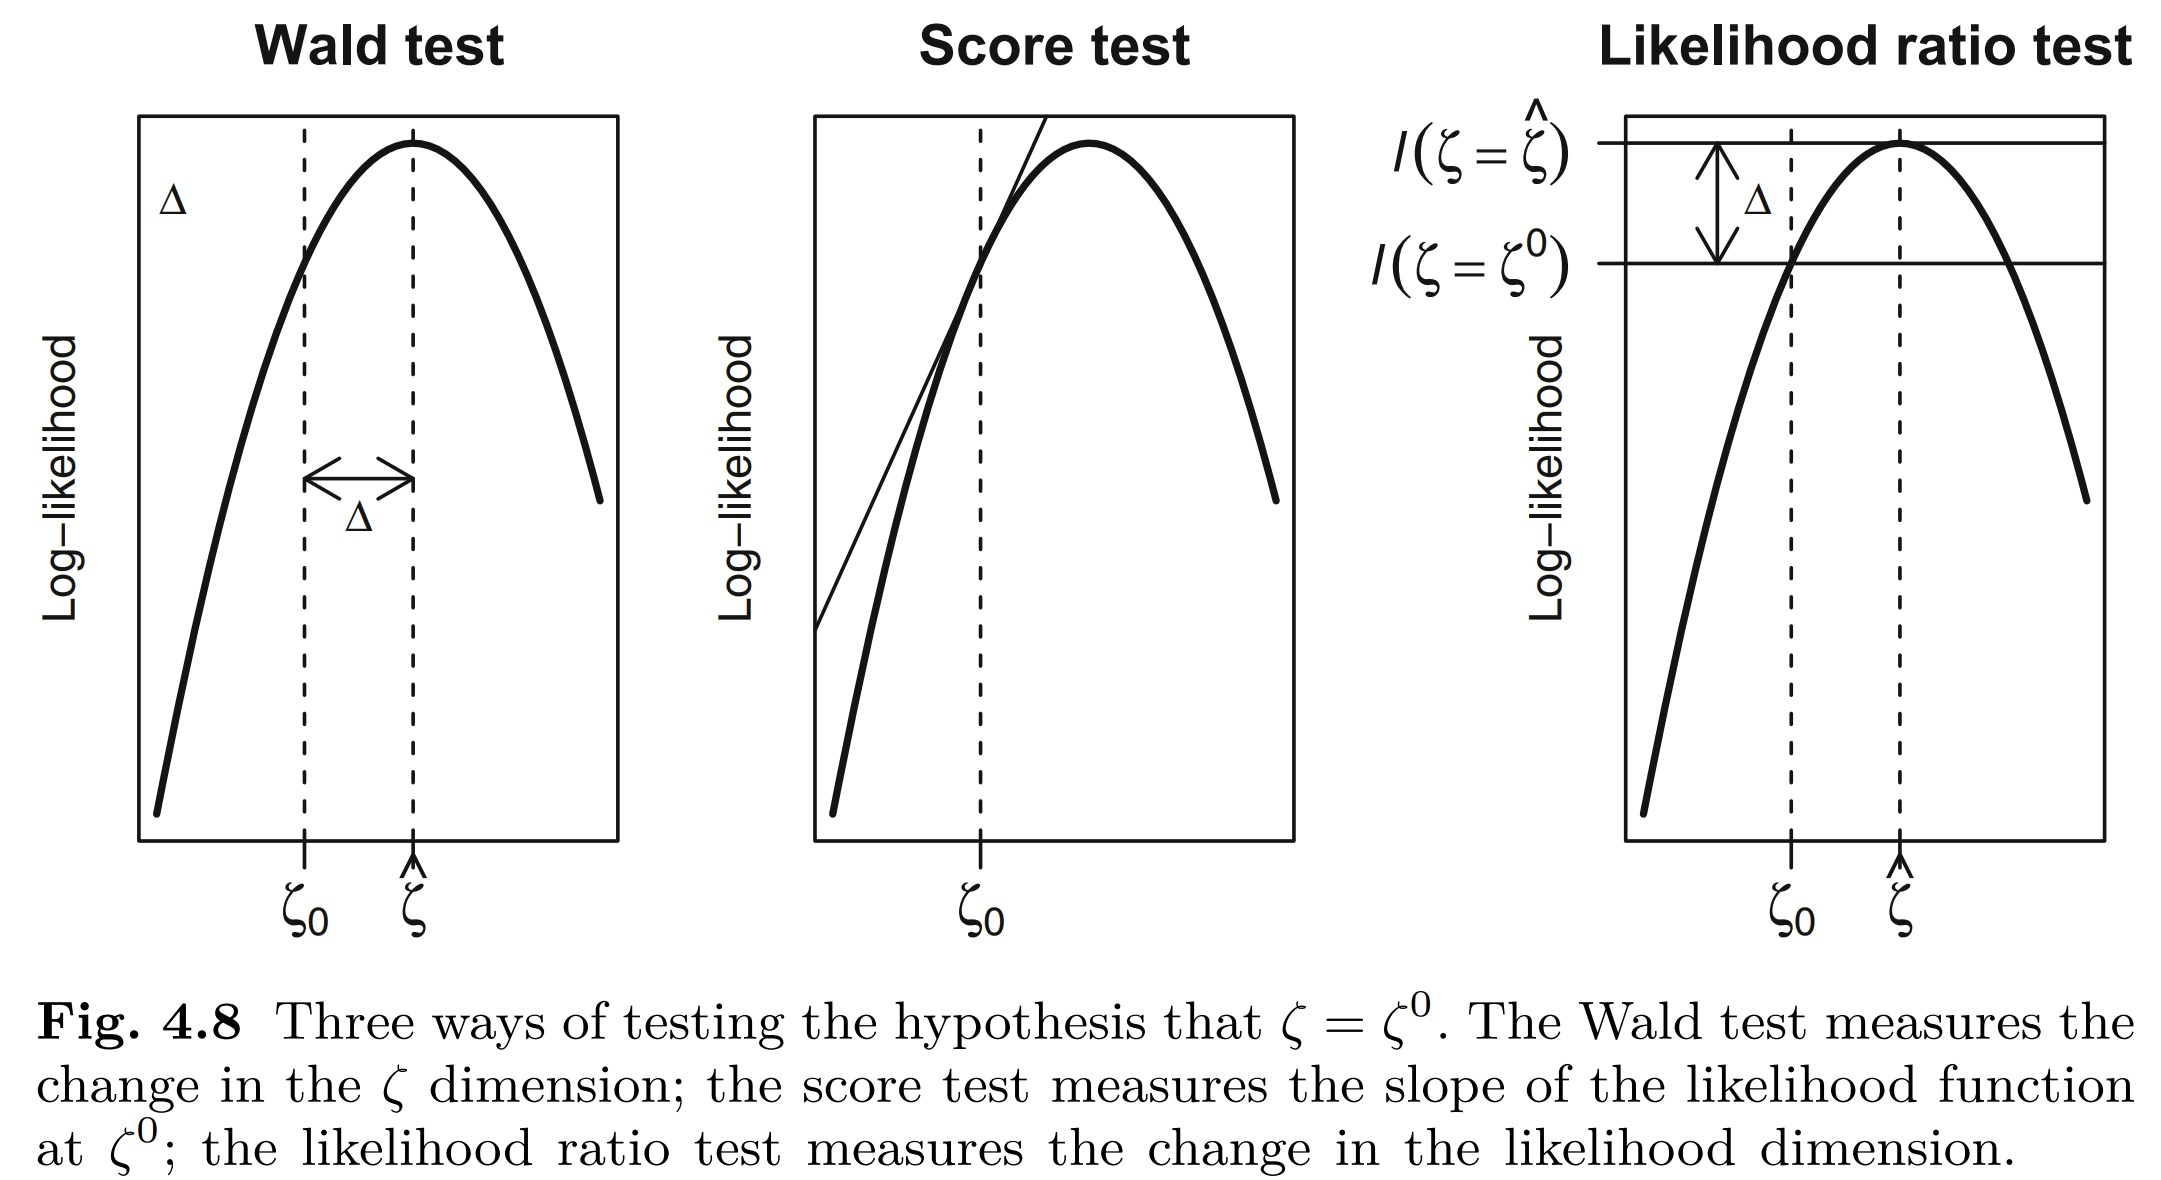

wald: zeta0 v intervale? delta?

Skore: derivacia, nula?

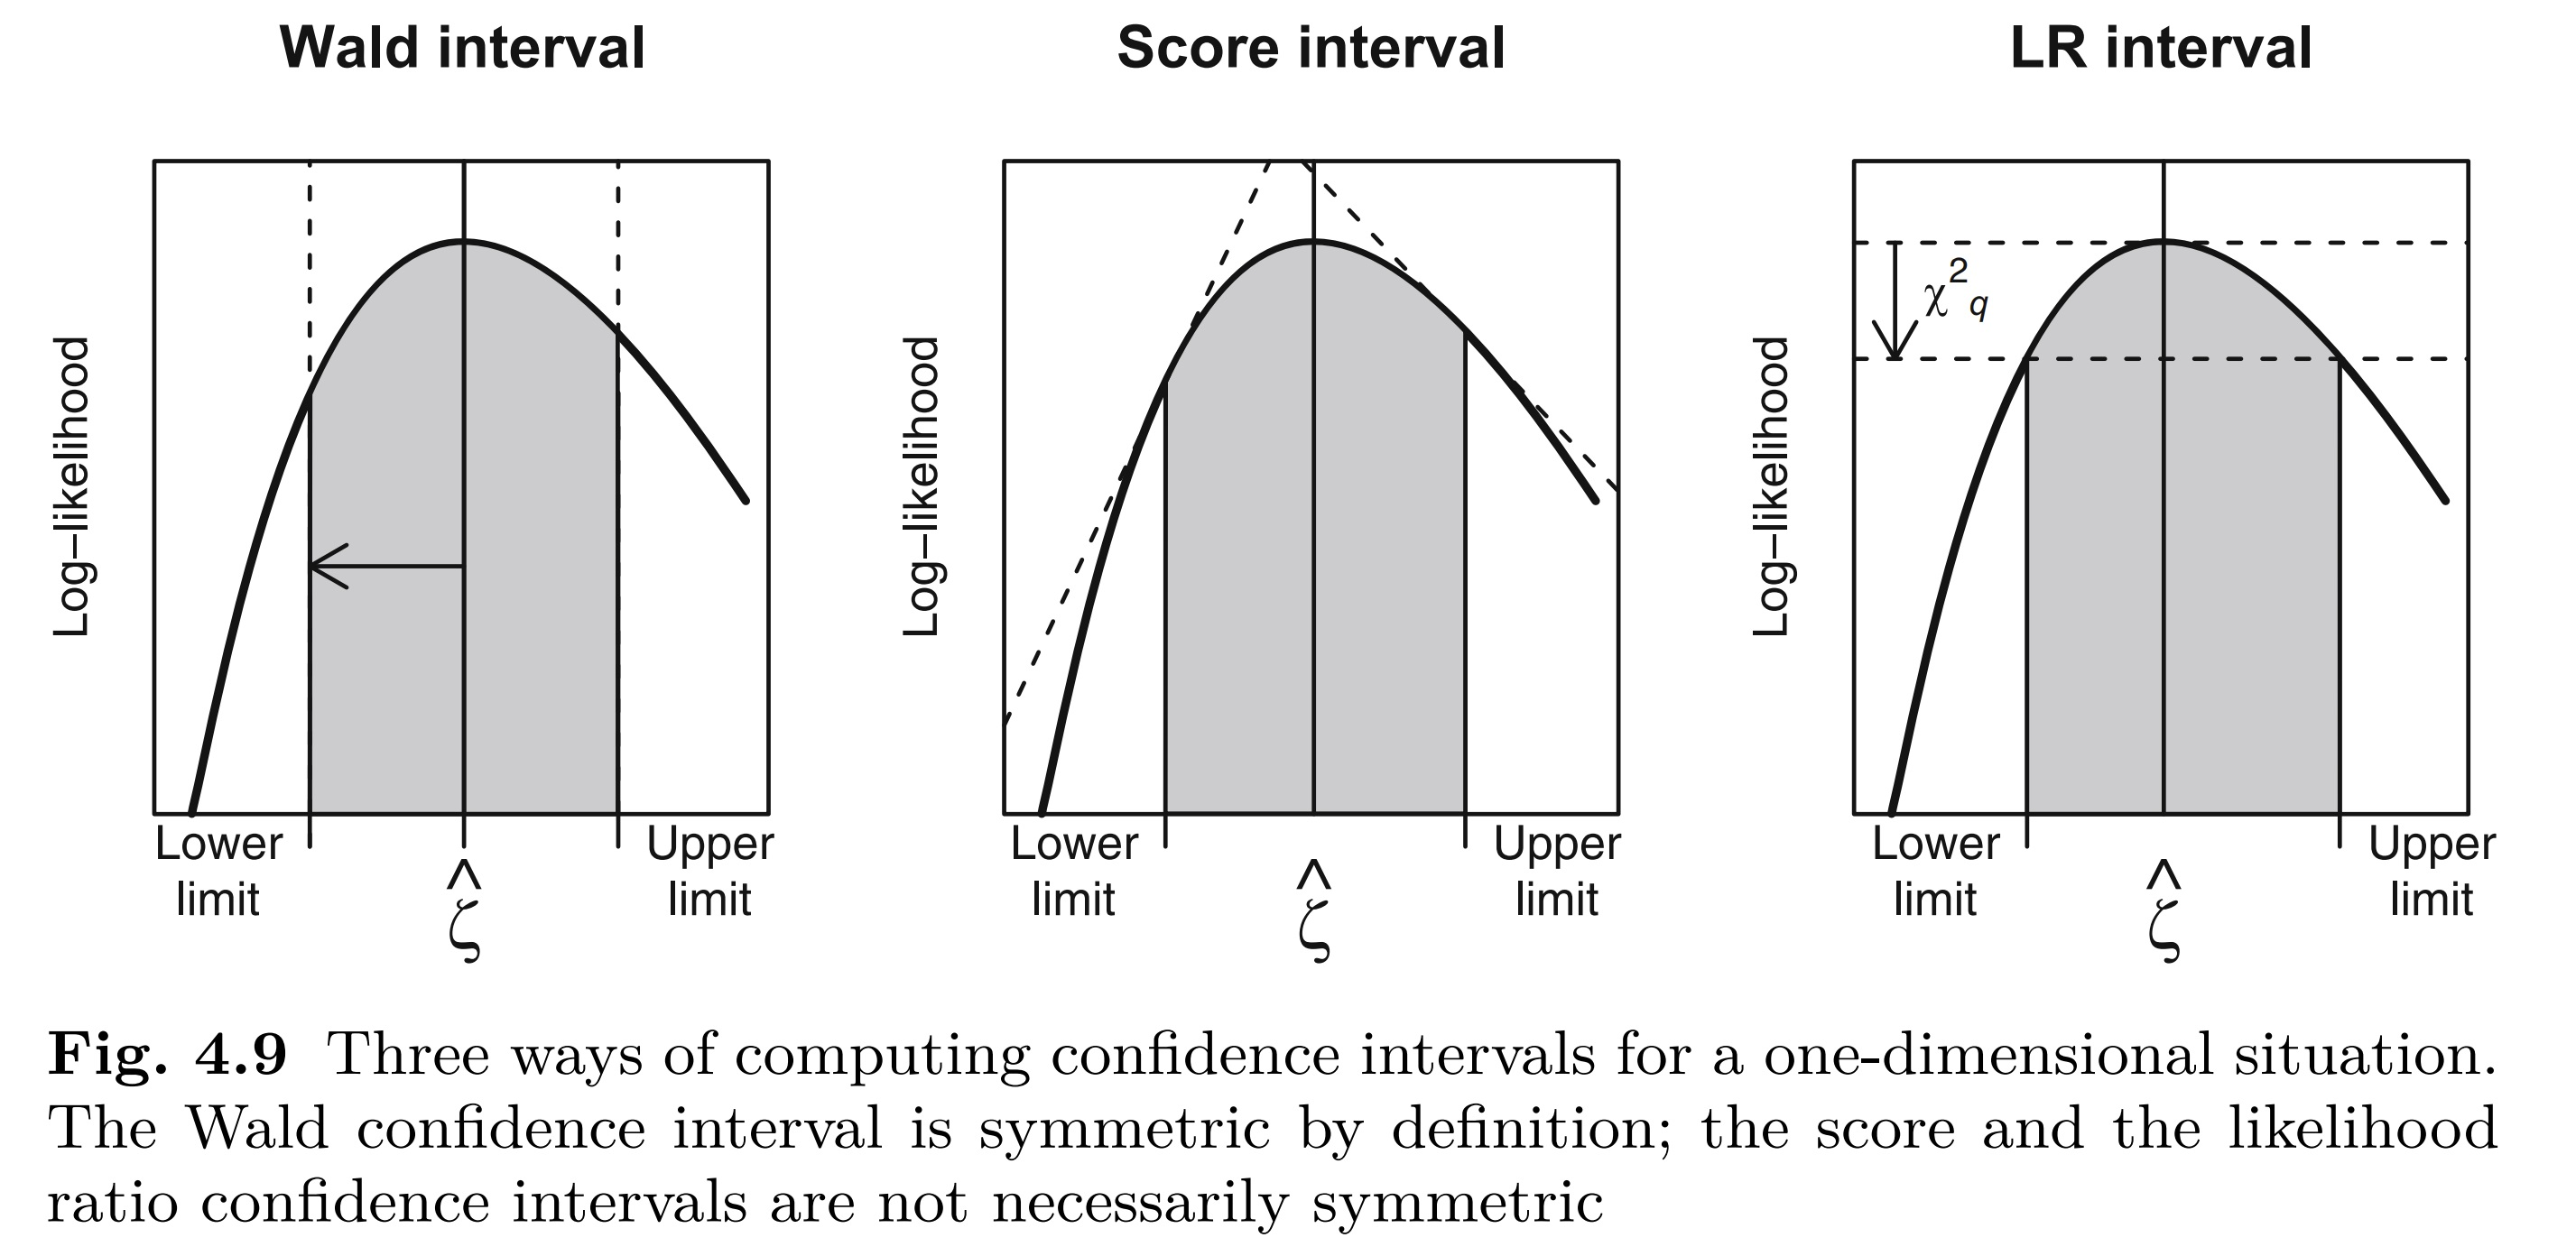

### Comparison of tests:
All three tests answer the same question: Can we leave out these predictor variables and reduce the fit of the model? 

All three tests can be used  when only one parameter appears in the model, or for all of the many parameters simultaneously, as well as for subsets of the parameters.

* Wald test is usually the easiest to perform
* Rao score tests  require less computational effort.
* Devince (i.e. Likelihood ratio tests) require **two models** to be fitted:


For Poisson model:
$$D = 2 \sum_{i=1}^n ( y_i log( \frac{y_i}{\hat{\mu_i}}) - ({y_i} - \hat{\mu_i}))$$

In [ ]:
mu_est_1 <- model_1$fitted.values
Y = nminer$Minerab
sum(Y -mu_est_1)
Y0 <- Y[Y>0]
mu0_est_1 <- mu_est_1[Y>0]
Dev_1 <- 2*sum(Y0*log(Y0/mu0_est_1))
Dev_1
Dev_1 <- 2*sum(Y0*log(Y0/mu0_est_1)) - 2*sum(Y -mu_est_1)
Dev_1


`deviance(fit)`
Returns the residual deviance $D(y,\hat{\mu})$ for the fitted GLM.

In [ ]:
deviance(model_1)

## Comparing Nested Models ($\phi$ is known)

### LRT Test

In [ ]:
model_0 <- glm( Minerab ~ 1,    data=nminer, family=poisson)
model_1 <- glm( Minerab ~ Eucs, data=nminer, family=poisson)

In [ ]:
print(cbind( "Dev(m0)"= deviance(model_0), "Dev(m1)" = deviance(model_1) ))

print(cbind( "df(m0)" = df.residual(model_0), "df(m1)" = df.residual(model_1)))

L <- deviance(model_0) - deviance(model_1)
L

pchisq(L, df.residual(model_0) - df.residual(model_1), lower.tail=FALSE )


In [ ]:
anova(model_0,model_1,test="LRT")

náš model (m1) je štat významne odlišný od m0 -> zamietame H0 o tom, že nie su odlišne (p-val malinkata)

In [ ]:
anova(model_1, test="Chisq")

The P-value is very small, indicating that the addition of Eucs is significant.

### Score test

In [ ]:
 # Add one variable
 library(statmod) # Provides glm.scoretest
 #? glm.scoretest
model_0<- glm( Minerab ~ 1, data=nminer, family=poisson)
z_stat <- glm.scoretest(model_0, nminer$Eucs)
p_val <- 2 * pnorm( abs(z_stat), lower.tail=FALSE)
p_val

In [ ]:
# Compare model with saturated model
Y <- nminer$Minerab
X <- nminer$Eucs
mu_est_1 <- model_1$fitted.values

Rao <- sum((Y-mu_est_1)^2/mu_est_1)
Rao
# p-hodnota testu adekvatnosti modelu (pomoci Raovy statistiky)
# H0: model dobre popisuje data
prao <- pchisq(Rao, model_1$df.residual, ncp=0, lower.tail = FALSE); 
prao

In [ ]:
I <- diag(1,length(Y),length(Y))
model_f <- glm(formula=Y~X,family=poisson(link = "log"))
model_s <- glm(formula=Y~I,family=poisson(link = "log"))
anova(model_f,model_s, test = "Rao")
anova(model_1,model_0, test = "Rao")


The evidence strongly suggests that Eucs should be added to the model.

fí nepotrebujem na odhad beta, ale potrebujeme ho na odhad rozptylu a std. FIM: $I^{-1}=\phi(X...)$

In [ ]:
summary(model_1) #????

## Estimating of $\phi$

* The Maximum Likelihood Estimator of $\phi$
* Pearson Estimator of $\phi$
* Mean Deviance Estimator of $\phi$

### Pearson Estimator of $\phi$

$$\phi = \frac{var[Y_i]}{a_i b''(\theta_i)} \Rightarrow \hat{\phi} = \frac{1}{n-p} \sum_{i=1}^{n} \frac{(y_i - \hat{\mu_i})^2}{a_i b''(\theta(\hat{\mu_i}))}$$

### Mean Deviance Estimator of $\phi$

$$\hat{\phi} = \frac{D(y,\hat{\mu})}{n-p}$$



For binomial and Poisson glms, $\phi = 1$ and no estimation is necessary. However, the issue may arise for over-dispersed binomial or Poisson GLMs,
which are considered in later exercises.

Use data `trees` and compute Pearson and Deviance estimator of $\phi$

In [ ]:
data(trees)
ggpairs(trees)

In [ ]:
model_trees_1 <- glm( Volume ~ log(Height) +  log(Girth), data=trees, family=Gamma(link="log"))
summary(model_trees_1)

In [ ]:
? weights.glm

In [ ]:
#Compute the Pearson estimator of $\phi$
w <- weights(model_trees_1, type="working") # working return results from the last iteration
e <- residuals(model_trees_1, type="working") #working rezidua
sum(w*e^2) / df.residual(model_trees_1)

In [ ]:
phi_meandev <- deviance(model_trees_1) / df.residual(model_trees_1)
phi_pearson <- summary(model_trees_1)$dispersion
cbind(Mean_deviance=phi_meandev, Pearson=phi_pearson)


odhady podobne

In [ ]:
coef(summary(model_trees_1, dispersion=phi_meandev))
coef(summary(model_trees_1))

Note though that R has now conducted z-tests using a normal distribution
instead of t-tests, treating the dispersion as known.

In [ ]:
model_trees_0 <- glm( Volume ~ 1, family=Gamma(link="log"), data=trees) #nulový
model_trees_G <- update(model_trees_0,.~.+ log(Girth) ) #iba z Gčok
model_trees_GH <- update(model_trees_G,.~.+ log(Height) ) #GH
cbind( deviance(model_trees_0), deviance(model_trees_G), deviance(model_trees_GH))
cbind( df.residual(model_trees_0), df.residual(model_trees_G), df.residual(model_trees_GH))

dev1 <- deviance(model_trees_0) - deviance(model_trees_G);dev1
dev2 <- deviance(model_trees_G) - deviance(model_trees_GH);dev2
df1 <- df.residual(model_trees_0) - df.residual(model_trees_G)
df2 <- df.residual(model_trees_G) - df.residual(model_trees_GH)


In [ ]:
F_Pearson <- c( dev1/df1, dev2/df2 ) / phi_pearson
F_meandev <- c( dev1/df1, dev2/df2 ) / phi_meandev
P_Pearson <- pf( F_Pearson, df1, df.residual(model_trees_GH), lower.tail=FALSE )
P_meandev <- pf( F_meandev, df2, df.residual(model_trees_GH), lower.tail=FALSE )
tab <- data.frame(F_Pearson, P_Pearson, F_meandev, P_meandev)
rownames(tab) <- c("Girth","Height")
print(tab, digits=3)

p_pearson -> male p hodnoty

In [ ]:
anova(model_trees_GH, test="F", dispersion=phi_meandev)
anova(model_trees_GH, test="F", dispersion=phi_pearson)

Questions:
* What if I swap the order of independet varialbes in the definition `Volume ~ Girth + Height`?
* Compute scores by adding Girth and Height to the null model by `glm.scoretest() `in r package `statmod`. Try both directions.

## Comparing Non-nested Models: The AIC and BIC

Assume we want to compare the models:
$$Model \ 1: \ \text{log} \mu = \beta_0 +  2 x_1 + \beta_2 x_2$$
$$Model \ 2: \ \text{log} \mu = \beta_0 + \beta_1 x_1 + \ x_2$$


modely nie sú do seba vnorené a nemožno ich porovnávať klasicky vierohodnosťami

In [ ]:
Model_1 <- glm( Volume ~ offset(2*log(Girth)) + log(Height), family=Gamma(link="log"), data=trees)
Model_2 <- glm( Volume ~ log(Girth) + offset(log(Height)), family=Gamma(link="log"), data=trees)
print('AIC')
cbind(AIC(Model_1), AIC(Model_2))
print('BIC')
cbind(BIC(Model_1), BIC(Model_2))


In [ ]:
p = 2 +1 # dispersion parameter
n = length(trees$Volume)
phi_hat = summary(Model_1)$dispersion

#AIC  = -2*logL(Model_1) + 2*p; AIC
#BIC  = -2*logL(Model_1) + p*log(n); BIC
# summary(Model_1)
AIC = deviance(Model_1)/phi_hat + 2*p; AIC

In [ ]:
summary(Model_1)

### Automated Selection

niečo podobne ako pomocou step function v RAD jak sme pouzivali

In [ ]:
model_0 <- glm( Volume~1, data=trees, family=Gamma(link="log"))
model_1 <- glm( Volume~log(Girth) + log(Height),data=trees, family=Gamma(link="log"))
model_b1 <- step(model_0, scope=list(lower=model_0, upper=model_1), direction="backward")
model_b2 <- step(model_1, scope=list(lower=model_0, upper=model_1), direction="backward")
model_b3 <- step(model_0, scope=list(lower=model_0, upper=model_1), direction="both") #snazime sa najsť najlepsi mode a zaciname modelom len s interceptom a hladááááááme
model_b3


# Next week: Exercise 05

## GLM Diagnostics and Analysis of residuals





## Your turn: Home work:

Problem 7.5. from: Peter K. Dunn · Gordon K. Smyth
Generalized Linear Models With Examples in R
https://link.springer.com/content/pdf/10.1007/978-1-4419-0118-7.pdf

Nambe Mills, Santa Fe, New Mexico, is a tableware manufacturer. After casting, items produced by Nambe Mills are shaped, ground, buffed, and
polished. In 1989, as an aid to rationalizing production of its 100 products, the company recorded the total grinding and polishing times and the diameter of each item (data set: nambeware). In this problem, only consider the item price y and item diameter x. In Problem 6.11, a glm was fitted to these data.

1. Use a Wald test to determine if diameter is significant.
2. Use a score test to determine if diameter is significant.
3. Use a likelihood ratio test to determine if diameter is significant.
296 REFERENCES
4. Compare the results from the Wald, score and likelihood ratio tests. Comment.
5. Is the saddlepoint approximation expected to be accurate? Explain.
6. Is the Central Limit Theorem expected to be accurate? Explain.
7. Find the 95% Wald confidence intervals for the regression coefficients.
8. Plot the price against diameter, and show the relationship described by
the fitted model. Also plot the lines indicating the lower and upper 95%
confidence intervals for these fitted value

In [ ]:
install.packages("GLMsData")
library(GLMsData)

In [ ]:
data(nambeware)
nambeware

In [ ]:
model_w <- glm( Price ~ Diam, data=nambeware, family=poisson, control=list(trace=F) ) # (link = "log")
coef(summary(model_1))
confint(model_1)